In [17]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

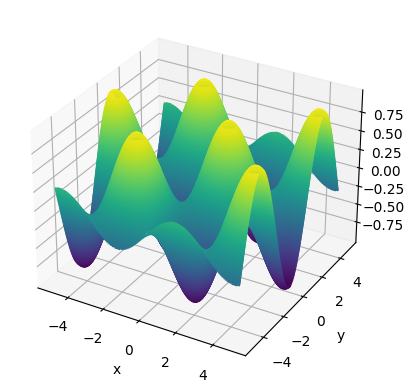

In [18]:
num_of_samples = 80
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y = np.meshgrid(x_data, y_data)
Z = np.sin(X)*np.cos(Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.contour3D(X, Y, Z, 200)
plt.show()

In [19]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1), Z.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

activation = nn.Sigmoid()

In [20]:
model = ELM(2, 500, 1).to(device)

In [21]:
H = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T.to(device)).T
T = trainset[:][1].reshape(1, -1).T.to(device)

In [22]:
def K(x):
    if x.dtype != torch.float64:
        x = torch.tensor(x, dtype=torch.float64).reshape(-1, 2).to(device)
    out = torch.exp(-torch.cdist(x, trainset[:][0].reshape(-1, 2).to(device), p=2) ** 2) @ T
    return out/max(out)

Train error: 0.26345684875839787
Test error: 0.23160331438206638


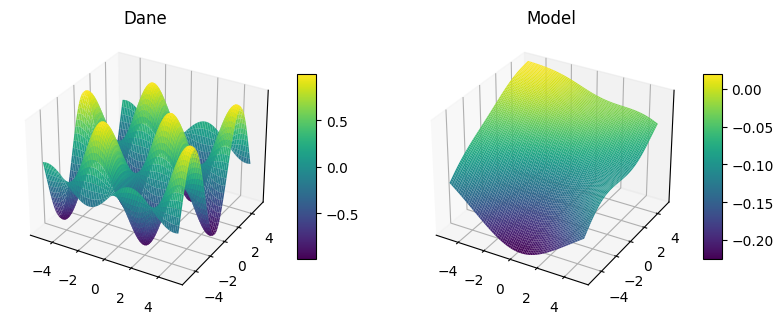

In [23]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 2).to(device))-trainset[:][1].reshape(-1, 1).to(device)).cpu().reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 2).to(device))-testset[:][1].reshape(-1, 1).to(device)).cpu().reshape(-1).pow(2).mean()}')
X, Y = np.meshgrid(x_data, y_data)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Dane')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(num_of_samples, num_of_samples), rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Model')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

In [24]:
import plotly.graph_objects as go

predictions = model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1).to(device)).cpu().detach().numpy().reshape(-1)
trace1 = go.Scatter3d(
    x=X.reshape(-1),
    y=Y.reshape(-1),
    z=Z.reshape(-1),
    mode='markers',
    marker=dict(
        size=2,
        color=Z.reshape(-1),
        colorscale='Viridis',
        colorbar=dict(title='Data - predicitions'),
    ),
    name='Model'
)
fig = go.Figure(data=[trace1], layout=dict(width=700, height=500))
# fig.update_layout(
#     scene = dict(
#         xaxis = dict(range=[-5,5]),
#         yaxis = dict(range=[-5,5]),
#         zaxis = dict(range=[-0.1,0.1]),),
#     width=700,
#     margin=dict(r=20, l=10, b=10, t=10)
# )
fig.show()